# Make Binary Charts, Relative Chart, Percent Activty Distribution Chart

The goal of this notebook is to produce the Binary Charts, Relative Chart, and Percent Activty Distribution Chart used in the Preliminary Analysis Presentation.

A description of what these charts do along with some analysis can be found in the "Description of Preliminary Results Presentation" Boxnote and the "Rat Behavior Coding and Data Analysis" word document.

Kush Attal can be credited with the multiindex organization of the dataframe and condensing my code to fit that. The original code that actually makes the frequency and binary charts was created by me.

An explanation of how this is done with examples can be found in the "Explanation of the 1s loop" word document.

There is a minor adjustment needed for the frequency diagrams and a description of the problem and a possible solution can be found in the "Adjustment needed for frequency rat behavior" word document. Please note that this only affects the frequency diagrams and *not* the binary diagrams. Only binary diagrams were used to produce the charts in this notebook.

In [21]:
#----------------------------------------------------------
# Import important libraries
#----------------------------------------------------------
import pandas as pd
import numpy as np
import datetime
import os 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [22]:
#Borrowed from Eric's Week 3 Rat code

#----------------------------------------------------------
# Set file path to necessary .xlsx files with training and test data
#----------------------------------------------------------
path = os.getcwd()
files = os.listdir(path)

#----------------------------------------------------------
# Collect all the .xlxs files into one list
#----------------------------------------------------------
xlsxfiles = [os.path.join(root, name)
             for root, dirs, files in os.walk(path)
             for name in files
             if name.endswith((".xlsx", ".xls"))]
#----------------------------------------------------------
# Extract each .xlsx file from the list into a single pandas dataframe
#----------------------------------------------------------
all_data = pd.DataFrame()
for i in xlsxfiles:
    df = pd.read_excel(i, index_col = "seconds")
    all_data = all_data.append(df)

In [23]:
#----------------------------------------------------------
# Create a copy of the dataframe with all the data and add columns logging which activity was performed at each time interval
#----------------------------------------------------------
all_data.copy = all_data.copy()
behaviors = ['Water', 'Feeding', 'Grooming', 'Rearing', 'Sleeping/Resting', 'Sucrose']
#Add columns that log which activity was performed (except for Zoomie)
for i in behaviors:
    behavior_column = (all_data.copy['Status'] >= 'START') & (all_data.copy['Behavior'] == i)
    all_data.copy[i + "_" + 'Activity'] = behavior_column.astype(int)
#Add column for Zoomie since it uses POINT to notify activity rather than START or STOP
zoom = (all_data.copy['Status']>= 'POINT') & (all_data.copy['Behavior'] == 'Zoomie')
all_data.copy['Zoomie_Activity'] = zoom.astype(int)

#### To change resampling, change the value in the parenthesis in the last line of the cell below.

In [41]:
#----------------------------------------------------------
# Create a dictionary holding all of the data separated by Rat number and resample all the data in windows of 5 seconds
#----------------------------------------------------------
all_data_dict = {}
for i in all_data.copy['Name'].unique():
    all_data_dict[i] = all_data.copy[all_data.copy.Name == i]
#select the following columns
    all_data_dict[i] = all_data_dict[i][['Water_Activity', 'Feeding_Activity', 'Grooming_Activity', 'Rearing_Activity', 'Sleeping/Resting_Activity', 'Sucrose_Activity', 'Zoomie_Activity']]
#resample all rats for 30s 
    all_data_dict[i] = all_data_dict[i].resample('120s').sum()

In [42]:
#----------------------------------------------------------
# Create a new dictionary that holds numpy arrays for all the columns in the previous dictionary (except for the index)
#----------------------------------------------------------
arrays = {}
for key in all_data_dict:
    for i in all_data_dict[key].columns:
        arrays[key + i] = np.array(all_data_dict[key][i])

In [43]:
#----------------------------------------------------------
# Loop through each numpy array and add "1"s (number that denotes activity) between intervals of START and STOP
# where activity is being performed but not recorded due to the resampling method
#----------------------------------------------------------
copies = {}
for key in arrays:
    if "Zoomie" not in key:
        #find the indexes of the nonzero values
        npcombinee = np.nonzero(arrays[key])[0]

        #make an array of one column
        np30c = np.array(arrays[key])
        copies[key] = np30c

        #loop through the nonzero indexes of the column
        for i in range(len(npcombinee)):
            #following is necessary to keep the loop in the range of the array, because of the 'i + 1'
            if i+1 < len(npcombinee):
                if arrays[key][:npcombinee[i]+1].sum() % 2 == 1 and arrays[key][:(npcombinee[i+1])].sum() % 2 == 1:
                    copies[key][npcombinee[i]+1:npcombinee[i+1]] = 1

In [44]:
#----------------------------------------------------------
# Transfer the corrected numpy arrays for the 5s resampling window to the original dictionary
#----------------------------------------------------------
#divide by two and round up to get rid of any double counting and set it equal to the correct column
for key in all_data_dict:
    for column in all_data_dict[key].columns:
        if "Zoomie" not in column:
            all_data_dict[key][column] = np.ceil(copies[key+column]/2)

#since Zoomies are point events the whole situation regarding changing 0s to 1s between Stop and Starts does not apply
#so this does not have to be rounded either
for key in all_data_dict:
    for column in all_data_dict[key].columns:
        if "Zoomie" in column:
            all_data_dict[key][column] = arrays[key+column]

## *Important*
## When adding new rats you have to manually put the name of the new rat in the "new_names" list in the cell below. Put it in alphabetical order and say whether the rat is Control or HFHS

In [45]:
#----------------------------------------------------------
#Combine all the dataframes in the model into one
#----------------------------------------------------------
all_data.rat = pd.concat(all_data_dict)
#Switch the indices so that the datetime is the leading index
all_data.date = all_data.rat.swaplevel()
#Sort the rat column index so that all the rats are grouped by the time interval - only problem is that since I am using a
#MultiIndex, the datetime Index is no longer possible unless I use "df.xs("Rat name", level = 1)" and subset for a certain rat
all_data.ml = all_data.date.sort_index()
#Rename the Rats to include diet Type
new_names = ['Rat02 Control', 'Rat03 Control', 'Rat05 Control', 'Rat06 Control', 'Rat07 Control', 'Rat08 Control', 'Rat21 HFHS','Rat22 HFHS', 'Rat23 HFHS', 'Rat26 HFHS']
all_data.ml.index.set_levels(new_names, level = 1, inplace = True)
#Add new column "Diet"
all_data.ml['Diet'] = all_data.ml.index.get_level_values(1)
all_data.ml["Diet"] = all_data.ml["Diet"].str.split().str[-1]

### Combine Binary Charts of Control and HFHS Rats

The goal of this is to see how many rats are performing an activity at a given time for each group. Each rat's frequency chart has to first be changed to a binary chart. These charts will then be summed with other binary charts for control and HFHS rats and plotted.

#### Change Frequency Chart to Binary Chart

In [46]:
#make variable activity_col with array in alphabetical order, this is necessary so that when making the bar plot
#the labels will correspond with the correct activity
activity_col = ['Feeding_Activity', 'Grooming_Activity',
       'Rearing_Activity', 'Sleeping/Resting_Activity', 'Sucrose_Activity', 'Water_Activity',
       'Zoomie_Activity']
#make a copy of the dataframe with frequency of behavior
all_data_1s = all_data.ml.copy()
#loop through each behavior column and change every nonzero value into 1 and set that equal to the original column
for i in activity_col:
    all_data_1s[i] = (all_data_1s[i] > .5).astype(int)
#add the 'Active' column to all_data_1s, this will represent when the rat is not Sleeping/Resting
all_data_1s['Active'] = 1 - all_data_1s['Sleeping/Resting_Activity']

When getting the charts after the behavior diagrams (using a resample of 500ms), it is suggested to hashtag out all of the next cell since it takes a long time for the computer to process.

Also, use the new cell as the last error check of the data. If the rat is doing behaviors that are not sleeping/resting or 'Active' for an extended amount of time, then there likely is an extra start or stop in the data making it flip.

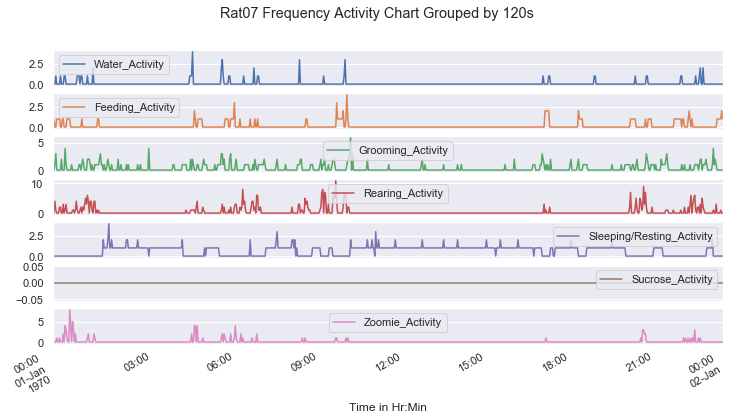

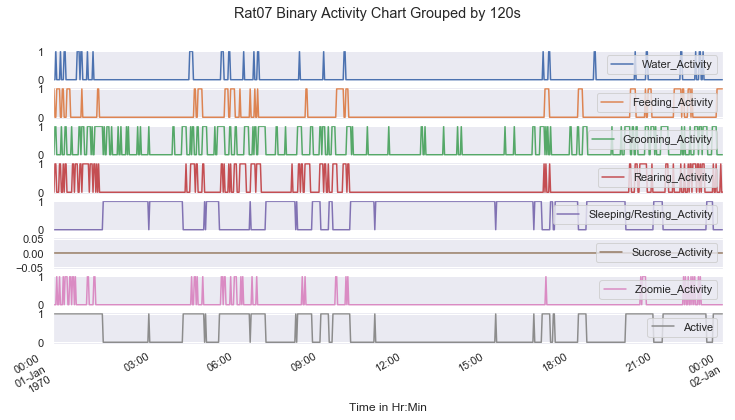

In [30]:
#plot example of 'frequency' activty chart for Rat21
all_data.ml.xs('Rat07 Control', level=1).plot(subplots=True, figsize=(12,6), title='Rat07 Frequency Activity Chart Grouped by 120s')
plt.xlabel('Time in Hr:Min')
plt.show()
#plot example of binary activty chart for Rat21
all_data_1s.xs('Rat07 Control', level=1).plot(subplots=True, figsize=(12,6), title='Rat07 Binary Activity Chart Grouped by 120s')
plt.xlabel('Time in Hr:Min')
plt.savefig('Rat07 Binary Chart')
plt.show()

## In the next two cells you will have to manually adjust some things if you are adding a new rat
In the cell below, adjust the number of control rats, control_num, to the correct amount.

In the cell below, adjust the number of HFHS rats, hfhs_num, to the correct amount.

In [47]:
#make variable for the number of rats in control and HFHS
control_num = 6
hfhs_num = 4

In the cell below, you will have to add the new rat to the control_1s df if it is a control rat or add the new rat to the HFHS_1s df if it is a HFHS rat. To do this, you will have to fill out the following template and paste it to the end of either control_1s or HFHS_1s as described above. Change the ## to the new rat number and change 'GROUP' to Control if it's in the control group or HFHS if it's in the HFHS group. Template:

.add(all_data_1s.xs('Rat## GROUP', level=1).drop(['Diet'],axis=1), fill_value=0)


In [48]:
#make variables control_1s and HFHS_1s by adding the binary control rat dataframes with each other and adding the
#HFHS dataframes with each other
control_1s = all_data_1s.xs('Rat02 Control', level=1).drop(['Diet'],axis=1).add(all_data_1s.xs('Rat03 Control', level=1).drop(['Diet'],axis=1), fill_value=0).add(all_data_1s.xs('Rat05 Control', level=1).drop(['Diet'],axis=1), fill_value=0).add(all_data_1s.xs('Rat06 Control', level=1).drop(['Diet'],axis=1), fill_value=0).add(all_data_1s.xs('Rat07 Control', level=1).drop(['Diet'],axis=1), fill_value=0).add(all_data_1s.xs('Rat08 Control', level=1).drop(['Diet'],axis=1), fill_value=0)
HFHS_1s = all_data_1s.xs('Rat22 HFHS', level=1).drop(['Diet'],axis=1).add(all_data_1s.xs('Rat23 HFHS', level=1).drop(['Diet'],axis=1), fill_value=0).add(all_data_1s.xs('Rat26 HFHS', level=1).drop(['Diet'],axis=1), fill_value=0).add(all_data_1s.xs('Rat21 HFHS', level=1).drop(['Diet'],axis=1), fill_value=0)
#divide by the number of rats in each group
control_1s_per = control_1s/control_num
HFHS_1s_per = HFHS_1s/hfhs_num

When getting the charts after the behavior diagrams (using a resample of 500ms), it is suggested to hashtag out all of the next cell since it takes a long time for the computer to process.

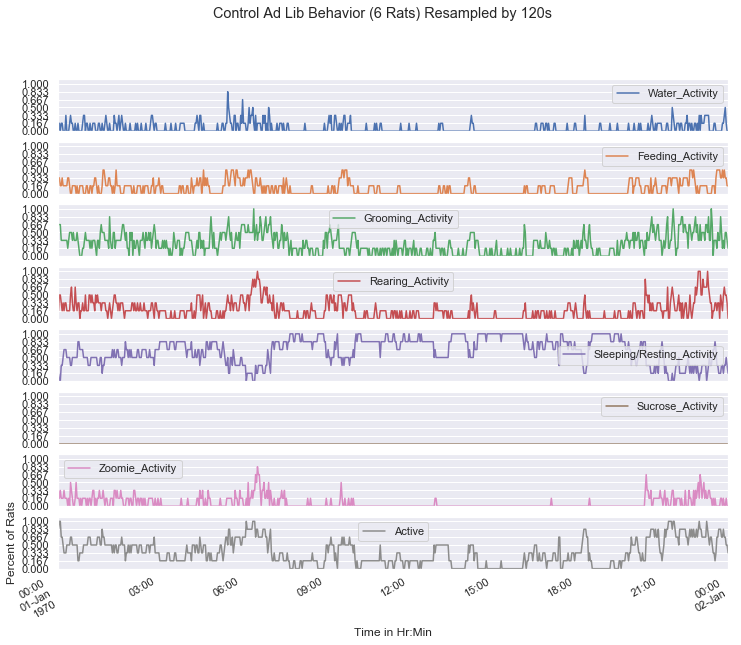

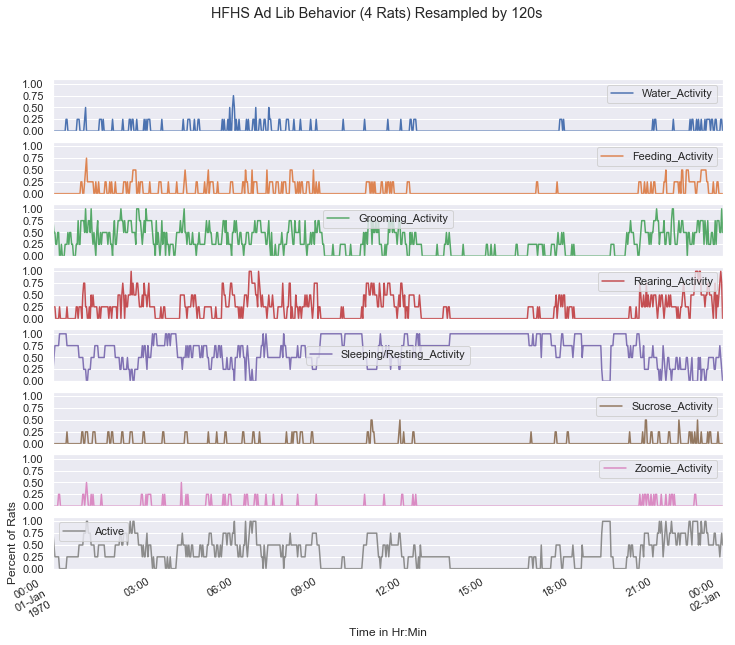

In [33]:
#plot the control rats behaviors
control_1s_per.plot(subplots=True, figsize=(12,10), ylim=(0,1.1), title='Control Ad Lib Behavior (6 Rats) Resampled by 120s', yticks =(np.arange(0, 2, step=1/6)))
plt.ylabel('Percent of Rats')
plt.xlabel('Time in Hr:Min')
plt.savefig('Control 120s Percent')
plt.show()
#plot the HFHS rat behaviors
HFHS_1s_per.plot(subplots=True, figsize=(12,10), ylim=(0,1.1), title='HFHS Ad Lib Behavior (4 Rats) Resampled by 120s', yticks =(np.arange(0, 2, step=.25)))
plt.ylabel('Percent of Rats')
plt.xlabel('Time in Hr:Min')
plt.savefig('HFHS 120s Percent')
plt.show()

Please note that one of the rats added into the HFHS Ad Lib Behavior did not have a recording for hour 19.

Both control and HFHS Rats show a strong connection between their circadian rythms and activity of each behavior. For both groups, there is a lot more drinking water, feeding, grooming, rearing, and zoomie activity during the night time (from 00:00 to 09:00 and 21:00 to 00:00) than the daytime (9:00 to 21:00). For the HFHS rats this is also seen in higher instances of drinking sucrose during the nighttime, although there are peaks around 12:00, which is during the daytime. This is also shown in the 'Active' columns of the two groups.

The control rats seemed to have drank water for a longer time than the HFHS rats overall. The control rats would also drink throughout the day, while the HFHS rats stopped drinking water after around 13:30 until it was nighttime (21:00), except for a few events at 18:00.

The control rats seemed to have spent a longer time feeding than the HFHS rats overall. The control rats would eat throughout the day, while the HFHS rats stopped eating after around 13:30 until it was nighttime (21:00), except for a few events at 18:00.

The HFHS rats seemed to have spent more time grooming overall then the control rats. The control rats followed their circadian rythm more closely with spikes in grooming right before daytime (9:00) and right after day ended (21:00). The HFHS also had spikes in grooming at these times but they also had a spike around 12:00.

The HFHS rats seemed to have spent more time rearing overall then the control rats. The control rats followed their circadian rythm more closely with spikes in rearing right before daytime (9:00) and right after day ended (21:00). The HFHS also had spikes in rearing at these times but they also had a spike around 12:00.

Sleeping activity for both groups looks pretty similar and follow their circadian rythm pretty close.

The HFHS rats drank sucrose with a similar pattern to when they were drinking water or feeding with most activity during the nighttime, but some activity until 13:30 and a few events around 18:00.

For both groups, their individual feeding and drinking (including sucrose for HFHS rats) activity occurred around the same time.

Rearing and grooming activity were also similar both groups, but more in the HFHS rats.

## Percent Activity in Day and Night

### *Change resample to '500ms', which is 0.5 seconds, to increase precision*

Here I tried to make graphs looking at when most of the activity of each behavior happened for each group and see if there was a difference in the percentage happening during each period.

In [49]:
#separate resampled dataframe into night and day
control_1s_n1 = control_1s['1970-01-01 00:00:00':'1970-01-01 09:00:00']
control_1s_n2 = control_1s['1970-01-01 21:00:00':]
control_1s_d = control_1s['1970-01-01 09:00:00':'1970-01-01 21:00:00']

HFHS_1s_n1 = HFHS_1s['1970-01-01 00:00:00':'1970-01-01 09:00:00']
HFHS_1s_n2 = HFHS_1s['1970-01-01 21:00:00':]
HFHS_1s_d = HFHS_1s['1970-01-01 09:00:00':'1970-01-01 21:00:00']

Relative Activity Bar Graphs


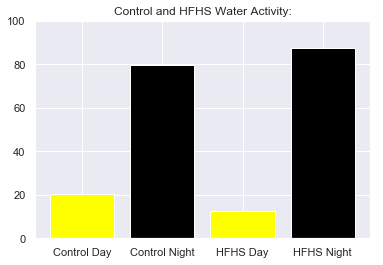

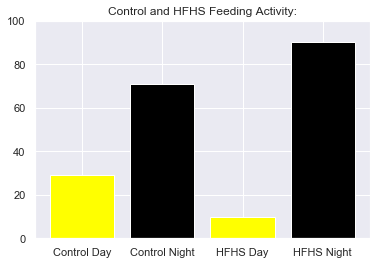

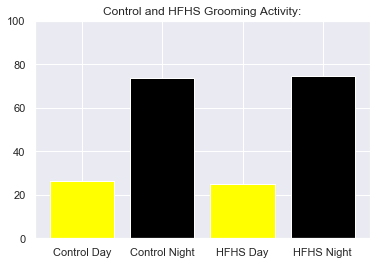

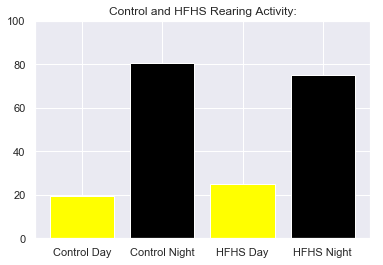

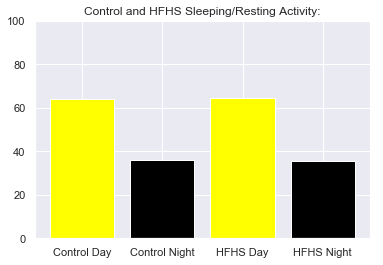

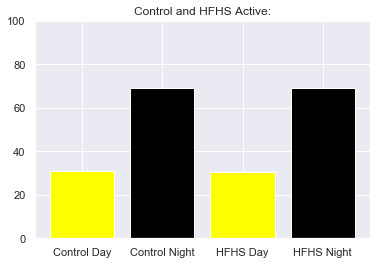

C:\Users\14eri\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
C:\Users\14eri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


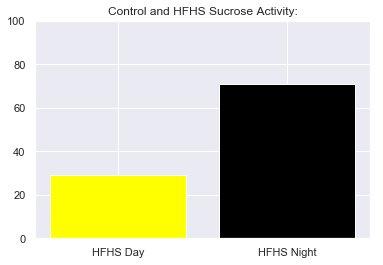

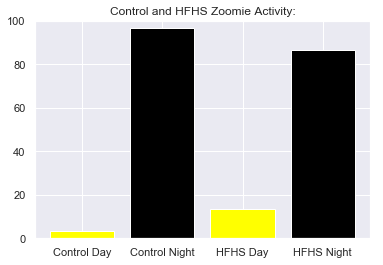

In [50]:
print('Relative Activity Bar Graphs')
ratcol = ['Water_Activity','Feeding_Activity','Grooming_Activity','Rearing_Activity','Sleeping/Resting_Activity','Active','Sucrose_Activity','Zoomie_Activity']
for i in range(len(ratcol)):
    #replace '_' with ' ' so the title looks better
    plt.title('Control and HFHS ' + ratcol[i].replace('_',' ') + ':')
    #get percent activity during night as described above
    con_night = ((control_1s_n1[ratcol[i]].sum() + control_1s_n2[ratcol[i]].sum())/control_1s[ratcol[i]].sum()) * 100
    #get percent activity during day as described above
    con_day = (control_1s_d[ratcol[i]].sum()/control_1s[ratcol[i]].sum()) * 100
    #get percent activity during night as described above
    night = ((HFHS_1s_n1[ratcol[i]].sum() + HFHS_1s_n2[ratcol[i]].sum())/HFHS_1s[ratcol[i]].sum()) * 100
    #get percent activity during day as described above
    day = (HFHS_1s_d[ratcol[i]].sum()/HFHS_1s[ratcol[i]].sum()) * 100
    #plot bar graph
    plt.bar('Control Day',con_day, color='yellow')
    plt.bar('Control Night',con_night, color='black')
    plt.bar('HFHS Day',day, color='yellow')
    plt.bar('HFHS Night',night, color='black')
    plt.ylim(0,100)
    plt.show()

Both groups had more activity during the night for water, feeding, grooming, rearing, and zoomie. HFHS rats had more sucrose activity during the night as well. Both groups slept more during the day and were more active at night.

HFHS rats had a higher percentage of activity during the night for water and feeding than control rats.

Grooming, rearing, sleeping, and 'active' was essentially the same for both rat groups.

Control rats had a higher percentage of activity during the night for zoomie than HFHS rats. Control rats also had a higher percentage of sleeping activty during the day than HFHS rats.

### Way to view it as means of percent activity of each rat and with standard deviation

While the previous printouts were interesting, they failed to show if these differences were statistically significant since they could not show error bars. In this section, I will make the same graphs but add error bars representing the standard deviation for each percentage. I will also add a "Drinking" column which is the sum of Water and Sucrose averaged for HFHS rats and divided by the average Water time of Control rats and a "Feeding and Sucrose" column which is the sum of Feeding and Sucrose averaged for HFHS rats and divided by the average Feeding time of Control rats.

In [51]:
#make empty lists
control_day = []
control_night = []
con_csv_names = []
hfhs_day = []
hfhs_night = []
hfhs_csv_names = []

#loop through new_names
for i in new_names:
    #select for only 'Control' rats
    if i[-7:] == 'Control':
        #select for each individual control rat dataframe
        df = all_data_1s.xs(i, level=1)
        #select for the activity columns
        #***** IMPORTANT *****
        #for Control rats DO NOT include Sucrose_Activity, because it will give divide by 0 error
        df = df[['Feeding_Activity', 'Grooming_Activity', 'Rearing_Activity',
       'Sleeping/Resting_Activity', 'Active','Water_Activity', 'Zoomie_Activity']]
        #add columns
        df['Drinking'] = df.Water_Activity
        df['Feeding and Sucrose'] = df.Feeding_Activity
        #select for the day from 9:00 to 21:00 and sum
        df_d = df['1970-01-01 09:00:00':'1970-01-01 21:00:00']
        #select for the night from 0:00 to 9:00 and sum
        df_n1 = df['1970-01-01 00:00:00':'1970-01-01 09:00:00']
        #select for the night from 21:00 to midnight and sum
        df_n2 = df['1970-01-01 21:00:00':]
        #calculate the percent of activity during the day
        df_dper = df_d.sum()/df.sum() *100
        #add the percent of activity during the day
        control_day.append(df_dper)
        con_csv_names.append(i[:5])
        #calculate the percent of activity during the night
        df_nper = df_n1.sum().add(df_n2.sum())/df.sum() *100
        #add the percent of activity during the night
        control_night.append(df_nper)
    if i[-4:] == 'HFHS':
        #select for each individual control rat dataframe
        df = all_data_1s.xs(i, level=1)
        #select for the activity columns
        #***** IMPORTANT *****
        #for HFHS rats include Sucrose_Activity, because it will give divide by 0 error
        df = df[['Feeding_Activity', 'Grooming_Activity', 'Rearing_Activity',
       'Sleeping/Resting_Activity', 'Active','Water_Activity', 'Zoomie_Activity', 'Sucrose_Activity']]
        #make new columns
        df['Drinking'] = df.Water_Activity + df.Sucrose_Activity
        df['Feeding and Sucrose'] = df.Feeding_Activity + df.Sucrose_Activity
        #select for the day from 9:00 to 21:00 and sum
        df_d = df['1970-01-01 09:00:00':'1970-01-01 21:00:00'].sum()
        #select for the night from 0:00 to 9:00 and sum
        df_n1 = df['1970-01-01 00:00:00':'1970-01-01 09:00:00'].sum()
        #select for the night from 21:00 to midnight and sum
        df_n2 = df['1970-01-01 21:00:00':].sum()
        #calculate the percent of activity during the day
        df_dper = df_d/df.sum() *100
        #add the percent of activity during the day
        hfhs_day.append(df_dper)
        hfhs_csv_names.append(i[:5])
        #calculate the percent of activity during the night
        df_nper = df_n1.add(df_n2)/df.sum() *100
        #add the percent of activity during the night
        hfhs_night.append(df_nper)

In [52]:
#combine the lists of series just found into one
df_con_d = pd.concat((control_day),axis=1)
df_con_n = pd.concat((control_night), axis=1)
df_h_d = pd.concat((hfhs_day), axis=1)
df_hfhs_n = pd.concat((hfhs_night), axis=1)

#make a list of the combined series
per_df_list = [df_con_d, df_con_n, df_h_d, df_hfhs_n]

#make an empty list for the combined series after that are manipulated in the loop
per_df_list_final = []

#make lists for adding features to the list of combined series as they go through the loop
names = [con_csv_names, con_csv_names, hfhs_csv_names, hfhs_csv_names]
group = ['Control','Control','HFHS','HFHS']
period = ['Light','Dark','Light','Dark']
diet = ['ad libitum', 'ad libitum', 'ad libitum', 'ad libitum']

#loop through the range of the number of combined series in the list of them
for i in range(len(per_df_list)):
    #set frame equal to one of the combined series
    frame = per_df_list[i]
    #transform the df
    frame = frame.T
    #give the frame an index found from the original loop
    frame.index = names[i]
    #give frame a column with the associated group, period, and diet
    frame['Group'] = group[i]
    frame['L_or_D'] = period[i]
    frame['Diet'] = diet[i]
    #select for dfs that are for Control rats in the light
    if group[i] == 'Control' and period[i] == 'Light':
        #add a sucrose column of 0s
        frame['Sucrose_Activity'] = 0
        #sort the columns in the df alphabetically
        frame = frame.sort_index(axis=1)
        #create variables to get the mean and std of each column
        con_light_mean = frame.mean()
        con_light_std = frame.std()
    #select for dfs that are for Control rats in the dark
    if group[i] == 'Control' and period[i] == 'Dark':
        #add a sucrose column of 0s
        frame['Sucrose_Activity'] = 0
        #sort the columns in the df alphabetically
        frame = frame.sort_index(axis=1)
        #create variables to get the mean and std of each column
        con_dark_mean = frame.mean()
        con_dark_std = frame.std()  
    #select for dfs that are for HFHS rats in the light
    if group[i] == 'HFHS' and period[i] == 'Light':
        #sort the columns in the df alphabetically
        frame = frame.sort_index(axis=1)
        #create variables to get the mean and std of each column
        hfhs_light_mean = frame.mean()
        hfhs_light_std = frame.std()
    #select for dfs that are for HFHS rats in the dark
    if group[i] == 'HFHS' and period[i] == 'Dark':
        #sort the columns in the df alphabetically
        frame = frame.sort_index(axis=1)
        #create variables to get the mean and std of each column
        hfhs_dark_mean = frame.mean()
        hfhs_dark_std = frame.std()
    #append the df into per_df_list_final
    per_df_list_final.append(frame)

#combine per_df_list_final into one df by column
per_df = pd.concat((per_df_list_final), axis=0, sort=False)
#save as csv
#per_df.to_csv('Percent Distribution of Activity.csv')

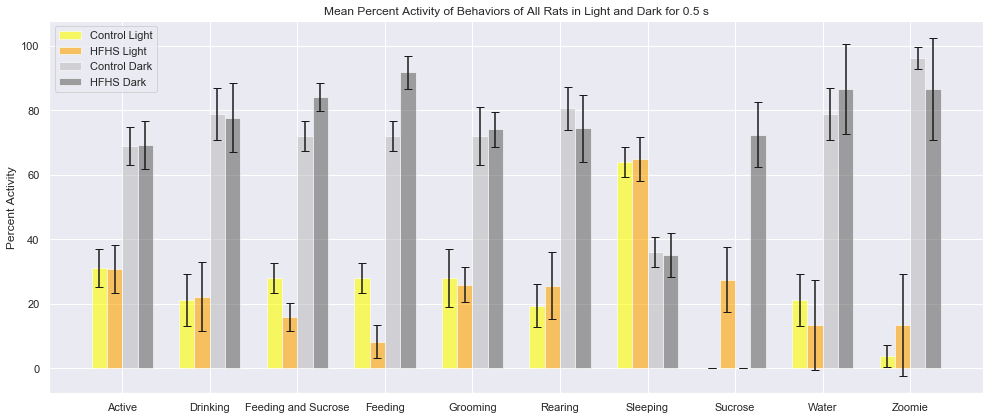

In [53]:
ind = np.arange(len(con_light_mean))  # the x locations for the groups
width = 0.175  # the width of the bars

#plot bar chart
fig, ax = plt.subplots(figsize=(14,6))
rects1 = ax.bar(ind - 3*width/2, con_light_mean, width, yerr=con_light_std,
                label='Control Light', color='yellow', alpha=0.6, capsize=4)
rects2 = ax.bar(ind - width/2, hfhs_light_mean, width, yerr=hfhs_light_std,
                label='HFHS Light', color='orange', alpha=0.6, capsize=4)
rects3 = ax.bar(ind + width/2, con_dark_mean, width, yerr=con_dark_std,
                label='Control Dark', color='silver', alpha=0.6, capsize=4)
rects4 = ax.bar(ind + 3*width/2, hfhs_dark_mean, width, yerr=hfhs_dark_std,
                label='HFHS Dark', color='dimgrey', alpha=0.6, capsize=4)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percent Activity')
ax.set_title('Mean Percent Activity of Behaviors of All Rats in Light and Dark for 0.5 s')
ax.set_xticks(ind)
ax.yaxis.grid(True)
ax.legend(loc='upper left')
ax.set_xticklabels(('Active','Drinking','Feeding and Sucrose','Feeding', 'Grooming', 'Rearing', 'Sleeping', 'Sucrose', 'Water','Zoomie'))

fig.tight_layout()
#plt.savefig('Mean Percent Activity of Behaviors of All Rats in Light and Dark (resampled for .5 s).png')
plt.show()

The chart indicates that there were only significant differences in the distribution of percent behavior in Feeding and in Feeding and Sucrose between the two groups. All other activities are within standard deviations of each other.

## Relative Time Spent 

Previously I looked into the relative time each group of control rats spent doing a behavior between night and day. This comparison was within the rat groups meaning that a 30% time spent grooming during the day meant that that rat group spent 30% of its total time grooming during the day. This comparison did not look at any differences in the total time spent grooming (or other behaviors)  between rat groups.

Below I look into the relative time spent on each activity by the HFHS rats in comparison to the Control rats. To do this, I found the total time spent on an behavior by the HFHS rats and divided it by the total time spent by the Control rats.

In [54]:
#make new dataframe of the sum of the hshf columns except for 'Sucrose_Activity' divided by the sum of the control
#columns except for 'Sucrose_Activity'
rel_time = (HFHS_1s.sum().drop('Sucrose_Activity')/hfhs_num)/(control_1s.sum().drop('Sucrose_Activity')/control_num)
#add 'Water and Sucrose' column to compare time drinking of HFHS rat to control rat by summing 'Water_Activity' and 
#'Sucrose_Activity' in both of the no nan dataframes and dividing the hfhs sum by the control sum
rel_time['Water and Sucrose'] = ((HFHS_1s.Water_Activity.sum() + HFHS_1s.Sucrose_Activity.sum())/hfhs_num)/((control_1s.Water_Activity.sum() + control_1s.Sucrose_Activity.sum())/control_num)

#add 'Feeding and Sucrose' column to compare time drinking of HFHS rat to control rat by summing 'Feeding_Activity' and 
#'Sucrose_Activity' in both of the no nan dataframes and dividing the hfhs sum by the control sum
rel_time['Feeding and Sucrose'] = ((HFHS_1s.Feeding_Activity.sum() + HFHS_1s.Sucrose_Activity.sum())/hfhs_num)/((control_1s.Feeding_Activity.sum() + control_1s.Sucrose_Activity.sum())/control_num)

#make new df with the series rel_time
rela = pd.DataFrame(rel_time)
#transform df
rela = rela.T

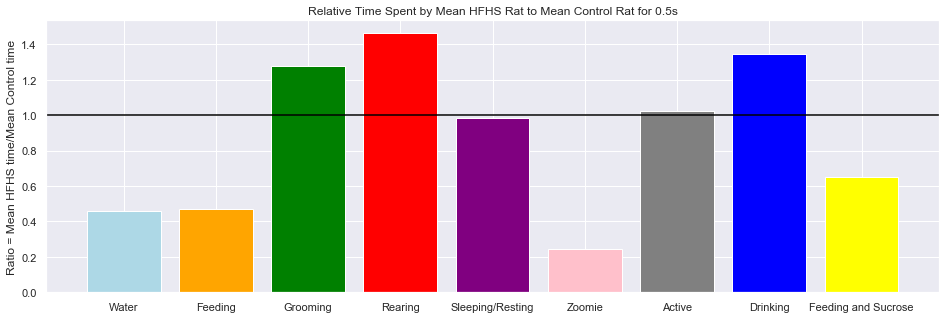

Water_Activity               0.457954
Feeding_Activity             0.472377
Grooming_Activity            1.278046
Rearing_Activity             1.461485
Sleeping/Resting_Activity    0.982797
Zoomie_Activity              0.243613
Active                       1.024759
Water and Sucrose            1.345505
Feeding and Sucrose          0.649904
dtype: float64


In [55]:
#get x positions
x_pos = np.arange(len(rela.columns))
#get heights of bars
height = rela.loc[0,:].values
#make bar names
bars = ['Water','Feeding','Grooming','Rearing','Sleeping/Resting','Zoomie','Active','Drinking','Feeding and Sucrose']
#plot the bar graph
plt.figure(figsize=(16,5))
plt.bar(x_pos, height, color=['lightblue', 'orange', 'green', 'red', 'purple', 'pink', 'grey','blue','yellow'])
#make line at 1 so it's easier to tell if the ratio is above or below 1
plt.axhline(1, color='black')
#label
plt.xticks(x_pos, bars)
plt.title('Relative Time Spent by Mean HFHS Rat to Mean Control Rat for 0.5s')
plt.ylabel('Ratio = Mean HFHS time/Mean Control time')
#plt.savefig('Relative Time Spent Resampled .5 s.png')
plt.show()

print(rel_time)

From the bar graph above one can see that the HFHS rats drank just water for 45% of the time the Control rats drank just water, HFHS rats fed for 47% of the time the Control rats fed, and did a zoomie 24% of the times the Control rats did a zoomie. The HFHS rats fed and drank sucrose for 65% of the time the Control rats fed. Please note that the Control rats did not have access to sucrose solution.

The HFHS rats groomed for 1.28 times the time than the Control rats did, reared for 1.46 times the time the Control rats did, and drank water and sucrose (total drinking) for 1.35 times the time the Control rats did. Please note that the Control rats did not have access to sucrose solution.

The HFHS rats slept/rested for about the same time as the Control rats. The HFHS rats slept/rested for about 98% of the time that the Control rats spent sleeping/resting. The HFHS rats were active for about the same time as the Control rats. The HFHS rats were active for about 102% of the time that the Control rats spent sleeping/resting.

It is interesting that the HFHS rats spent less time acquiring calories (Feeding and Sucrose) than the Control rats (just Feeding). This likely indicates that drinking sucrose gives more calories per second than feeding does.